# Example notebook demonstrating the thermal energy relationships

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
import coop_setup_funcs as csf
from astropy import constants
import healpy as hp
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.size']=14
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['text.usetex']=False
import stats as st
import sys

## Calculations

$y$ is defined as

$y = \frac{k_B \sigma_T}{m_e c^2} \int d\ell n_e T_e$

where $d\ell$ is the line-of-sight element.
The angular-integrated $Y$ signal is defined as:

$Y=\int_\Omega y d\Omega = \int_A y \frac{dA}{d_Z^2(z)}$

where $d_A$ is the angular diameter distance. However, it is easier to work with the intrinsic $Y$ (which does not depend on distance),


$Y^{\rm{int}} = Y d^2_A = \frac{k_B \sigma_T}{m_e c^2} \int_V T_e n_e dV$

where $d_V$ is the volume element. This more physical quantity is what we refer to as $Y$ in the paper. The electron pressure is:

$P_e = k_B  T_e n_e $,

which means also that

$P_e \approx y \frac{m_e c^2}{\sigma_T} / L$

where $L$ is an estimate of the line-of-sight extent of the object.

The electron pressure is related to the thermal pressure as:

$P_{\rm{e}} = P_{\rm{th}} \bigg[ \frac{4-2X_{\rm{He}}}{8-5X_{\rm{He}}}\bigg]$

The thermal energy in general is just

$E_{\rm{th}} = \int P_{\rm{th}} dV$

So substituting in, we get

$Y^{\rm{int}} = \frac{\sigma_T}{m_e c^2} \bigg[ \frac{4-2X_{\rm{He}}}{8-5X_{\rm{He}}} \bigg]  E_{\rm{th}}$

i.e.

$E_{\rm{th}} = \frac{m_e c^2}{\sigma_T} \bigg[ \frac{8-5X_{\rm{He}}}{4-2X_{\rm{He}}} \bigg] Y^{\rm{int}}$

In [2]:
def integrate(profile, r, upper_bound, errors=None):
    reimann_sum = 0
    error_sum   = 0
    delta_r = r[1]-r[0]
    ub_idx = (np.abs(r - upper_bound)).argmin()
    for i in range(ub_idx+1):    
        reimann_sum += r[i]*profile[i]*delta_r
        if errors is not None:
            error_sum += (delta_r*r[i]*errors[i])**2
        
        
    return(reimann_sum*np.pi, np.sqrt(error_sum)*np.pi)

In [3]:

def get_TE(int_Y, midz, hefrac=0.24):
    m_e = constants.m_e
    c   = constants.c
    sigma_T = constants.sigma_T
    # convert int_Y from comoving Mpc to physical Mpc
    int_Y *= u.Mpc**2*cosmo.scale_factor(midz)**2
    TE = (8-5*hefrac)/(4-2*hefrac)*(m_e*c**2/sigma_T)*int_Y
    return TE
def get_Pe(y, est_los):
    # convert from Compton y units to electron pressure units
    m_e = constants.m_e
    c   = constants.c
    sigma_T = constants.sigma_T
    Pe = (m_e*c**2/sigma_T)*y/(est_los)
    return Pe

In [4]:
obspath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"

# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
obspath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
mask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24
acty_mapstr = f'ilc_SZ_yy_4096_hpx'
buzzy_mapstr = f'ymap_buzzard_fid_hpx'
buzzy_mapstr_break = 'ymap_buzzard_break_bbps_car_1p6arcmin_cutoff4_alphabreak0.972_4096_hpx'



In [5]:
def retrieve_stack_info(path, mapstr, pt_selection_str, cl_dbin, cutmin=20, pct=75, orient_mode='maglim', xyup=True, binsize=7.5, crop_center=2.5, scale=None, make_delta=False, remove_r30=False):
    if xyup:
        xyupstr = '_orientXYUP'
    else:
        xyupstr = ''
    
    cl_dlow, cl_dhi = cl_dbin[0], cl_dbin[1] # extent of the clusters
    
    g_dlow   = cl_dlow-50 # extent of the galaxies
    g_dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    
    file = path + f"{mapstr}_redmapper_lambdagt{cutmin}_combined_{cl_dlow}_{cl_dhi}Mpc_{pt_selection_str}20pt0{xyupstr}_{pct}pct_{orient_mode}_{g_dlow}_{g_dhi}Mpc_{nreg}reg_m0to5_profiles.pkl"
    stack_info = np.load(file, allow_pickle=True)
    # rearrange shape of profs to be compatible with Stack_object
    profs = np.transpose(np.asarray(stack_info['prof']), axes=[2,0,1])
    if crop_center is not None:
        rmax = len(profs[0,0,:])
        r_in_mpc = 40/rmax*np.arange(rmax)
        idx_crop = np.where(np.abs(r_in_mpc-crop_center) == np.min(np.abs(r_in_mpc-crop_center)))[0][0]
        # cut off profiles up to 2.5 Mpc
        profs = profs[:,:,idx_crop:]
    
    if scale is not None:
        profs *= scale
    stack_obj = cpp.Stack_object(img_splits=stack_info['stacks'], profile_splits=profs, Npks_splits=stack_info['npks_list'], rad_in_Mpc=40)
    if crop_center is not None:
        # reset r of stack_obj to account for 2.5 Mpc cut
        stack_obj.r = stack_obj.r[idx_crop:]
    
    if make_delta:
        # find the average matter density over the extent of the redshift range
        rholist = []
        # plt.figure(figsize=(10,10))
        for chi in np.linspace(cl_dlow, cl_dhi,100):
            chibinsize = (cl_dhi-cl_dlow)/100
            zmid = z_at_value(cosmo.comoving_distance, (chi+chibinsize)/2*u.Mpc)
            rho_avg_chi = cosmo.Om(z=zmid)* cosmo.critical_density0.to(u.Msun/u.Mpc**3)
            # multiply it by the bin size to get the average surface mass density in the bin
            rho_avg_bin = rho_avg_chi * chibinsize * u.Mpc
            rholist.append(rho_avg_bin.value)
        avg_matter = np.average(rholist)
        print("average rho in this bin", avg_matter)
        stack_obj.profile_splits[:,:,:] /= avg_matter
        # convert 2D delta to 3D delta by estimating length of object along line of sight
        est_los = 10 # Mpc
        stack_obj.profile_splits[:,:,:] /= est_los
    if remove_r30:
        idx_r30 = np.where(np.abs(stack_obj.r-30) == np.min(np.abs(stack_obj.r-30)))[0][0]
        for r in range(stack_obj.profile_splits.shape[1]):
            avg_r30 = np.average(stack_obj.profile_splits[0,r,:][idx_r30:])
            stack_obj.profile_splits[0,r,:] -= avg_r30
        
        
    stack_obj.set_average_profiles()
    stack_obj.bin_and_get_stats(binsize) #Mpc
    return stack_obj, (zlow, zhi)


In [6]:
# First, test what we get for just the central stacked cluster pressure

# pull the kappa data and the y data
ylims = np.array([-1e12, 3e12])
deslens_mapstr = 'kappa_bin4'
acty_mapstr = f'ilc_SZ_yy_4096_hpx'

# set up figure with n_dbin cols, 5 rows

colors = ['red', 'blue', 'green', 'orange']
for col, dbin in enumerate(dbins):
    midz = z_at_value(cosmo.comoving_distance, (dbin[0]+dbin[1])/2*u.Mpc)
    act_obj, (zlow,zhi) = retrieve_stack_info(obspath, acty_mapstr, pt_selection_str, dbin, crop_center = 0, binsize=2, remove_r30=True)
    # integrate the profiles
    itgl_y,err_y =   integrate(act_obj.avg_profiles_binned[0], act_obj.r_binned, 5)
    print(itgl_y)
    # convert y to pressure
    int_Pe = get_Pe(act_obj.avg_profiles_binned[0],  3*u.Mpc)
    print(int_Pe.to(u.keV/u.cm**3))

    

1.960776501854084e-05
[ 1.55251493e-04  1.59500022e-05  1.26915860e-05  1.12127443e-05
  5.69913203e-06  6.93854835e-06  8.49559148e-06  7.28711660e-06
  7.17879033e-06  4.70804781e-06  3.05004622e-06  2.69459675e-06
  2.02029890e-06  4.17337937e-07  5.33327406e-07  1.21897604e-06
  3.73956298e-07  5.09783002e-07 -8.70127967e-08 -4.18401504e-07] keV / cm3
2.2736610480757936e-05
[ 1.76624795e-04  2.74438629e-05  1.70080029e-05  1.18594335e-05
  1.15730703e-05  1.42366046e-05  1.26431474e-05  9.33032596e-06
  8.83138128e-06  8.27580638e-06  6.54832173e-06  5.84482163e-06
  4.39127389e-06  2.63895738e-06  2.84789588e-06  2.25707203e-06
  1.92687577e-06  3.49757212e-07 -3.00364324e-07 -4.42146848e-07
  3.93396561e-07 -5.40878352e-07] keV / cm3
1.9595377236895172e-05
[ 1.49306480e-04  1.95639554e-05  1.12832639e-05  1.70680643e-05
  1.61159219e-05  1.30422295e-05  1.23191382e-05  1.14243760e-05
  8.71273648e-06  4.24212734e-06  4.26795713e-06  3.21136523e-06
  2.16094695e-06 -2.40235095e-07

## these values make sense compared to what is in the literature.

integral adding, r= 5.292096219931271 profile= 3070474078435.159 delta_r= 5.498281786941582 full 89342923787676.5
integral adding, r= 10.790378006872853 profile= 2587525385992.181 delta_r= 5.498281786941582 full 153514100438406.75
integral adding, r= 5.292096219931271 profile= 1.498817595038096e-07 delta_r= 5.498281786941582 full 4.36117494381723e-06
integral adding, r= 10.790378006872853 profile= 8.357175846622393e-08 delta_r= 5.498281786941582 full 4.95819032054781e-06
integral adding, r= 5.292096219931271 profile= 3070474078435.159 delta_r= 5.498281786941582 full 89342923787676.5
integral adding, r= 10.790378006872853 profile= 2587525385992.181 delta_r= 5.498281786941582 full 153514100438406.75
integral adding, r= 16.288659793814436 profile= 1839456983876.9219 delta_r= 5.498281786941582 full 164741107990252.6
integral adding, r= 21.786941580756015 profile= 1085062784484.3734 delta_r= 5.498281786941582 full 129980478334094.84
integral adding, r= 5.292096219931271 profile= 1.498817595

Text(0, 0.5, 'Thermal Energy per Mass (GeV/M$_\\odot$)')

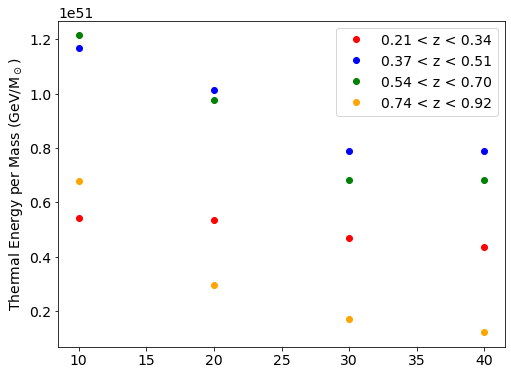

In [ ]:
# now get the thermal energy per mass
# pull the kappa data and the y data
ylims = np.array([-1e12, 3e12])
deslens_mapstr = 'kappa_bin4'
acty_mapstr = f'ilc_SZ_yy_4096_hpx'

# set up figure with n_dbin cols, 5 rows

xlims = [2.5,40]
colors = ['red', 'blue', 'green', 'orange']
for col, dbin in enumerate(dbins):
    desm_obj, (zlow,zhi) = retrieve_stack_info(obspath, deslens_mapstr, pt_selection_str, dbin, crop_center=2.5, binsize=6)
    # plt.plot(desm_obj.r_binned, desmdelt_obj.avg_profiles_binned[0], label=f"DES {zlow:.2f} < z < {zhi:.2f}, m=0", color=colors[col])
    
    # plt.ylabel("$\delta_m$")
    act_obj, (zlow,zhi) = retrieve_stack_info(obspath, acty_mapstr, pt_selection_str, dbin, crop_center = 2.5, binsize=6, remove_r30=True)
    # integrate the profiles
    ints_m = []
    ints_y = []
    for Rmax in [10,20,30,40]:
        itgl_m,err_l = integrate(desm_obj.avg_profiles_binned[0], desm_obj.r_binned, Rmax)
        itgl_y,err_y = integrate(act_obj.avg_profiles_binned[0], act_obj.r_binned, Rmax)
        ints_m.append(itgl_m)
        ints_y.append(itgl_y)
    plt.plot([10,20,30,40], get_TE(np.array(ints_y)).to(u.GeV).value/np.array(ints_m), 'o', color=colors[col], label=f"{zlow.value:.2f} < z < {zhi.value:.2f}")
    # convert y to pressure
   
    
plt.legend()
plt.ylabel("Thermal Energy per Mass (GeV/M$_\odot$)")

integral adding, r= 5.292096219931271 profile= 3070474078435.159 delta_r= 5.498281786941582 full 89342923787676.5
integral adding, r= 10.790378006872853 profile= 2587525385992.181 delta_r= 5.498281786941582 full 153514100438406.75
integral adding, r= 5.292096219931271 profile= 3070474078435.159 delta_r= 5.498281786941582 full 89342923787676.5
integral adding, r= 10.790378006872853 profile= 2587525385992.181 delta_r= 5.498281786941582 full 153514100438406.75
integral adding, r= 16.288659793814436 profile= 1839456983876.9219 delta_r= 5.498281786941582 full 164741107990252.6
integral adding, r= 21.786941580756015 profile= 1085062784484.3734 delta_r= 5.498281786941582 full 129980478334094.84
integral adding, r= 5.292096219931271 profile= 3070474078435.159 delta_r= 5.498281786941582 full 89342923787676.5
integral adding, r= 10.790378006872853 profile= 2587525385992.181 delta_r= 5.498281786941582 full 153514100438406.75
integral adding, r= 16.288659793814436 profile= 1839456983876.9219 delta

Text(0, 0.5, 'Integrated Excess Mass (M$_\\odot$)')

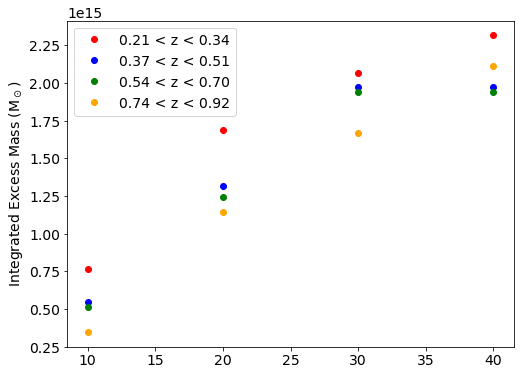

In [ ]:
# now get the thermal energy per mass
# pull the kappa data and the y data
ylims = np.array([-1e12, 3e12])
deslens_mapstr = 'kappa_bin4'
acty_mapstr = f'ilc_SZ_yy_4096_hpx'

# set up figure with n_dbin cols, 5 rows

xlims = [2.5,40]
colors = ['red', 'blue', 'green', 'orange']
for col, dbin in enumerate(dbins):
    desm_obj, (zlow,zhi) = retrieve_stack_info(obspath, deslens_mapstr, pt_selection_str, dbin, crop_center=2.5, binsize=6)
    # plt.plot(desm_obj.r_binned, desmdelt_obj.avg_profiles_binned[0], label=f"DES {zlow:.2f} < z < {zhi:.2f}, m=0", color=colors[col])
    
    # plt.ylabel("$\delta_m$")
    act_obj, (zlow,zhi) = retrieve_stack_info(obspath, acty_mapstr, pt_selection_str, dbin, crop_center = 2.5, binsize=6, remove_r30=True)
    # integrate the profiles
    ints_m = []
    ints_y = []
    for Rmax in [10,20,30,40]:
        itgl_m,err_l = integrate(desm_obj.avg_profiles_binned[0], desm_obj.r_binned, Rmax)
        ints_m.append(itgl_m)
    plt.plot([10,20,30,40], np.array(ints_m), 'o', color=colors[col], label=f"{zlow.value:.2f} < z < {zhi.value:.2f}")
    # convert y to pressure
   
    
plt.legend()
plt.ylabel("Integrated Excess Mass (M$_\odot$)")

integral adding, r= 5.292096219931271 profile= 1.498817595038096e-07 delta_r= 5.498281786941582 full 4.36117494381723e-06
integral adding, r= 10.790378006872853 profile= 8.357175846622393e-08 delta_r= 5.498281786941582 full 4.95819032054781e-06
integral adding, r= 5.292096219931271 profile= 1.498817595038096e-07 delta_r= 5.498281786941582 full 4.36117494381723e-06
integral adding, r= 10.790378006872853 profile= 8.357175846622393e-08 delta_r= 5.498281786941582 full 4.95819032054781e-06
integral adding, r= 16.288659793814436 profile= 7.918235796855531e-08 delta_r= 5.498281786941582 full 7.091543591047857e-06
integral adding, r= 21.786941580756015 profile= 3.3564012418290954e-08 delta_r= 5.498281786941582 full 4.020658022119997e-06
integral adding, r= 5.292096219931271 profile= 1.498817595038096e-07 delta_r= 5.498281786941582 full 4.36117494381723e-06
integral adding, r= 10.790378006872853 profile= 8.357175846622393e-08 delta_r= 5.498281786941582 full 4.95819032054781e-06
integral adding,

Text(0, 0.5, 'Integrated Thermal Energy (GeV)')

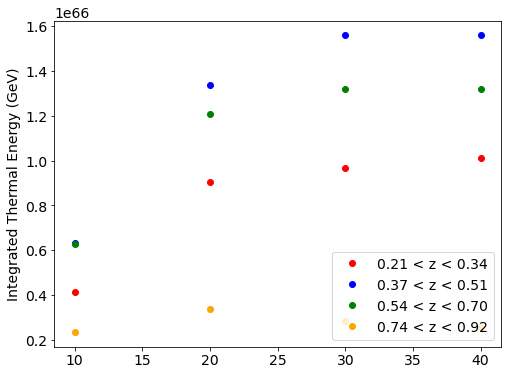

In [ ]:
# now get the thermal energy per mass
# pull the kappa data and the y data
ylims = np.array([-1e12, 3e12])
deslens_mapstr = 'kappa_bin4'
acty_mapstr = f'ilc_SZ_yy_4096_hpx'

# set up figure with n_dbin cols, 5 rows

xlims = [2.5,40]
colors = ['red', 'blue', 'green', 'orange']
for col, dbin in enumerate(dbins):
    desm_obj, (zlow,zhi) = retrieve_stack_info(obspath, deslens_mapstr, pt_selection_str, dbin, crop_center=2.5, binsize=6)
    # plt.plot(desm_obj.r_binned, desmdelt_obj.avg_profiles_binned[0], label=f"DES {zlow:.2f} < z < {zhi:.2f}, m=0", color=colors[col])
    
    # plt.ylabel("$\delta_m$")
    act_obj, (zlow,zhi) = retrieve_stack_info(obspath, acty_mapstr, pt_selection_str, dbin, crop_center = 2.5, binsize=6, remove_r30=True)
    # integrate the profiles
    # ints_m = []
    ints_y = []
    for Rmax in [10,20,30,40]:
        # itgl_m,err_l = integrate(desm_obj.avg_profiles_binned[0], desm_obj.r_binned, Rmax)
        itgl_y,err_y = integrate(act_obj.avg_profiles_binned[0], act_obj.r_binned, Rmax)
        # ints_m.append(itgl_m)
        ints_y.append(itgl_y)
    plt.plot([10,20,30,40], get_TE(np.array(ints_y)).to(u.GeV).value, 'o', color=colors[col], label=f"{zlow.value:.2f} < z < {zhi.value:.2f}")
    # convert y to pressure
   
    
plt.legend()
plt.ylabel("Integrated Thermal Energy (GeV)")

integral adding, r= 5.292096219931271 profile= 6.333628945745722e-09 delta_r= 5.498281786941582 full 1.842923645483339e-07
integral adding, r= 10.790378006872853 profile= 8.848861243888614e-08 delta_r= 5.498281786941582 full 5.249900082580084e-06
integral adding, r= 5.292096219931271 profile= 6.333628945745722e-09 delta_r= 5.498281786941582 full 1.842923645483339e-07
integral adding, r= 10.790378006872853 profile= 8.848861243888614e-08 delta_r= 5.498281786941582 full 5.249900082580084e-06
integral adding, r= 16.288659793814436 profile= 8.916085716651445e-08 delta_r= 5.498281786941582 full 7.985214401705764e-06
integral adding, r= 21.786941580756015 profile= 6.044233769682433e-08 delta_r= 5.498281786941582 full 7.240432607038015e-06
integral adding, r= 5.292096219931271 profile= 6.333628945745722e-09 delta_r= 5.498281786941582 full 1.842923645483339e-07
integral adding, r= 10.790378006872853 profile= 8.848861243888614e-08 delta_r= 5.498281786941582 full 5.249900082580084e-06
integral ad

Text(0, 0.5, 'Integrated Thermal Energy in $m=2$ (GeV)')

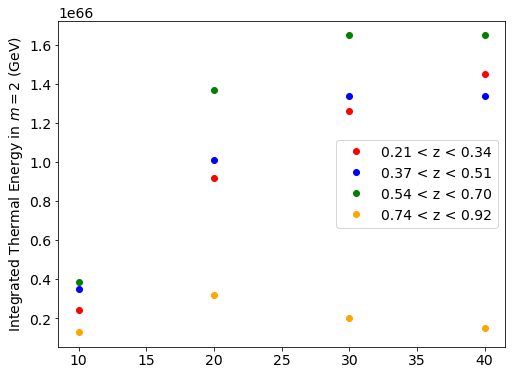

In [ ]:
# now get the thermal energy per mass
# pull the kappa data and the y data
ylims = np.array([-1e12, 3e12])
deslens_mapstr = 'kappa_bin4'
acty_mapstr = f'ilc_SZ_yy_4096_hpx'

# set up figure with n_dbin cols, 5 rows

xlims = [2.5,40]
colors = ['red', 'blue', 'green', 'orange']
for col, dbin in enumerate(dbins):
    desm_obj, (zlow,zhi) = retrieve_stack_info(obspath, deslens_mapstr, pt_selection_str, dbin, crop_center=2.5, binsize=6)
    # plt.plot(desm_obj.r_binned, desmdelt_obj.avg_profiles_binned[0], label=f"DES {zlow:.2f} < z < {zhi:.2f}, m=0", color=colors[col])
    
    # plt.ylabel("$\delta_m$")
    act_obj, (zlow,zhi) = retrieve_stack_info(obspath, acty_mapstr, pt_selection_str, dbin, crop_center = 2.5, binsize=6, remove_r30=True)
    # integrate the profiles
    # ints_m = []
    ints_y = []
    for Rmax in [10,20,30,40]:
        # itgl_m,err_l = integrate(desm_obj.avg_profiles_binned[0], desm_obj.r_binned, Rmax)
        itgl_y,err_y = integrate(act_obj.avg_profiles_binned[2], act_obj.r_binned, Rmax)
        # ints_m.append(itgl_m)
        ints_y.append(itgl_y)
    plt.plot([10,20,30,40], get_TE(np.array(ints_y)).to(u.GeV).value, 'o', color=colors[col], label=f"{zlow.value:.2f} < z < {zhi.value:.2f}")
    # convert y to pressure
   
    
plt.legend()
plt.ylabel("Integrated Thermal Energy in $m=2$ (GeV)")

In [ ]:
np.asarray(ints_m)/10**15

array([8.09742541e-15, 2.48426303e-14, 4.93158021e-14, 6.44227180e-14])

# And the same for galaxies

integral adding, r= 5.292096219931271 profile= 0.0015266342436070818 delta_r= 5.498281786941582 full 0.04442114259689718
integral adding, r= 10.790378006872853 profile= 0.002225688704574922 delta_r= 5.498281786941582 full 0.13204685882056671
integral adding, r= 5.292096219931271 profile= 6.333628945745722e-09 delta_r= 5.498281786941582 full 1.842923645483339e-07
integral adding, r= 10.790378006872853 profile= 8.848861243888614e-08 delta_r= 5.498281786941582 full 5.249900082580084e-06
integral adding, r= 5.292096219931271 profile= 0.0015266342436070818 delta_r= 5.498281786941582 full 0.04442114259689718
integral adding, r= 10.790378006872853 profile= 0.002225688704574922 delta_r= 5.498281786941582 full 0.13204685882056671
integral adding, r= 16.288659793814436 profile= 0.0022458261209728123 delta_r= 5.498281786941582 full 0.20113538221629187
integral adding, r= 21.786941580756015 profile= 0.0015279826304122482 delta_r= 5.498281786941582 full 0.18303817624853094
integral adding, r= 5.292

Text(0, 0.5, 'Thermal Energy per Galaxy (weird units)')

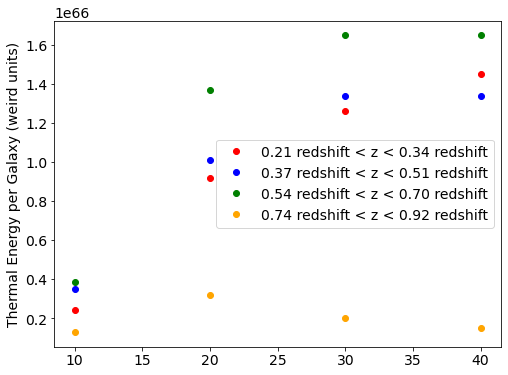

In [ ]:
# now get the thermal energy per mass
# pull the kappa data and the y data
ylims = np.array([-1e12, 3e12])

acty_mapstr = f'ilc_SZ_yy_4096_hpx'

# set up figure with n_dbin cols, 5 rows

xlims = [2.5,40]
colors = ['red', 'blue', 'green', 'orange']
for c, dbin in enumerate(dbins):
    desg_mapstr = f'DES_maglim_z_{zbins[c]}'
    desg_obj, (zlow,zhi) = retrieve_stack_info(obspath, desg_mapstr, pt_selection_str, dbin, crop_center=2.5, binsize=6)
    # plt.plot(desm_obj.r_binned, desmdelt_obj.avg_profiles_binned[0], label=f"DES {zlow:.2f} < z < {zhi:.2f}, m=0", color=colors[col])
    
    # plt.ylabel("$\delta_m$")
    act_obj, (zlow,zhi) = retrieve_stack_info(obspath, acty_mapstr, pt_selection_str, dbin, crop_center = 2.5, binsize=6, remove_r30=True)
    # integrate the profiles
    ints_m = []
    ints_y = []
    for Rmax in [10,20,30,40]:
        itgl_m,err_l = integrate(desg_obj.avg_profiles_binned[2], desg_obj.r_binned, Rmax)*u.Msun
        itgl_y,err_y =integrate(act_obj.avg_profiles_binned[2], act_obj.r_binned, Rmax)
        ints_m.append(itgl_m)
        ints_y.append(itgl_y)
    plt.plot([10,20,30,40], get_TE(np.array(ints_y)).to(u.GeV), 'o', color=colors[c], label=f"{zlow:.2f} < z < {zhi:.2f}")
    # convert y to pressure
   
    
plt.legend()
plt.ylabel("Thermal Energy per Galaxy (weird units)")